# Part_4: Stroke_Prediction - Modele klasyfikacji
W tej części przeprowadzę klasyfikację za pomocą modeli
1. Model regresji logistycznej
2. Random Forest Classifier
3. Naive Bayes Classifier
4. Support Vector Machine Classifier

Z powodu zastosowania systemów optymalizacji sklearn.pipeline i GridSearchCV niektóre modele bardzo długo się liczą. 
Dlatego zostały one zablokowane.

In [1]:
import time
start_time = time.time() ## pomiar czasu: start pomiaru czasu
print(time.ctime())
print('Pomiar czasu wykonania tego zadania')

Wed Mar  4 15:33:16 2020
Pomiar czasu wykonania tego zadania


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df= pd.read_csv('c:/1/Stroke_Prediction_NUM.csv' , nrows = 29000)
# , nrows = 290
headers = ['ID', 'Gender', 'Hypertension', 'Heart_Disease', 'Ever_Married',
       'Type_Of_Work', 'Residence', 'Avg_Glucose', 'BMI', 'Smoking_Status',
       'Stroke', 'Age_years', 'Age_years_10', 'Gender_C', 'Ever_Married_C',
       'Type_Of_Work_C', 'Residence_C', 'Smoking_Status_C', 'Age_years_10_C']
grupa_testowa= pd.read_csv('c:/1/Stroke_Prediction_NUM.csv', skiprows = 29000, header=None, names=headers)
# , nrows = 1000
print(df.shape)
print(grupa_testowa.shape)
df.head(5)

(29000, 20)
(63, 19)


,Unnamed: 0,ID,Gender,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke,Age_years,Age_years_10,Gender_C,Ever_Married_C,Type_Of_Work_C,Residence_C,Smoking_Status_C,Age_years_10_C
0,0,30650,Male,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0,58.093151,"(53.126, 59.076]",1,1,2,1,1,5
1,1,57008,Female,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0,70.076712,"(65.121, 74.11]",0,1,2,0,0,7
2,2,53725,Female,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0,52.041096,"(48.082, 53.126]",0,1,2,1,0,4
3,3,41553,Female,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0,75.104110,"(74.11, 82.137]",0,1,3,0,1,8
4,4,16167,Female,0,0,Yes,Private,Rural,77.67,32.3,smokes,0,32.024658,"(29.055, 36.058]",0,1,2,0,2,1


### <span style="color:blue">Wprowadzam zmienną syntetyczną</span>

Wprowadzanie zmiennych syntetycznych może poprawić zdolności klasyfikacyjne modelu.
Tę zmienną zrobiłem, aby pokazać, że stosuję tę technikę.

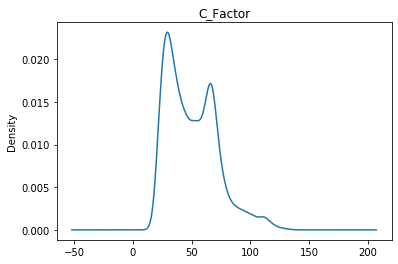

In [3]:
df['C_Factor'] = (df['BMI']+(5*(df['Age_years_10_C']*df['Smoking_Status_C'])))
fig, ax = plt.subplots()
df['C_Factor'].plot.kde(ax=ax, legend=False, title='C_Factor')

### <span style="color:blue">Analiza poziomu zbilansowania zmiennej wynikowej</span>

In [4]:
del df['Unnamed: 0']
df.Stroke.value_counts(dropna = False, normalize=True)

0    0.981172
1    0.018828
Name: Stroke, dtype: float64

Zbiór zmiennych wynikowych wymaga zbilansowania. Do bilansowania zmiennych wynikowych stosuję trzy metody:
- class_weight (http://sigmaquality.pl/models/classification/logistic-regression/model-regresji-logistyczne-czesc-4-zastosowanie-class_weight/)
-  oversampling (http://sigmaquality.pl/models/classification/logistic-regression/model-regresji-logistycznej-czesc-2-oversampling/)
- zmiana progu (http://sigmaquality.pl/models/classification/logistic-regression/model-regresji-logistycznej-czesc-3-zmiana-progu-w-modelu-regresji-logistycznej/)

Wszystkie trzy metody powinny dać podobne efekty przy klasyfikacji. Dzisiaj do zbilansowania zbioru zastosuję metodę oversampling. Oversampling odbywa się na zbiorze treningowym, więc najpierw trzeba podzielić zbiór na treningowy i testowy.

### <span style="color:blue">2. Podział na zbiór testowy i wynikowy</span>

In [5]:
df2 = df[['C_Factor','Hypertension','Heart_Disease','Avg_Glucose','BMI','Stroke','Age_years','Gender_C','Ever_Married_C','Type_Of_Work_C','Residence_C','Smoking_Status_C','Age_years_10_C']]

In [6]:
y = df2['Stroke']
X = df2.drop('Stroke', axis=1)

In [7]:
from sklearn.model_selection import train_test_split 
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.33, stratify = y, random_state = 148)

print ('Zbiór X treningowy: ',Xtrain.shape)
print ('Zbiór X testowy:    ', Xtest.shape)
print ('Zbiór y treningowy: ', ytrain.shape)
print ('Zbiór y testowy:    ', ytest.shape)

Zbiór X treningowy:  (19430, 12)
Zbiór X testowy:     (9570, 12)
Zbiór y treningowy:  (19430,)
Zbiór y testowy:     (9570,)


In [8]:
print("ytrain = 0: ", sum(ytrain == 0))
print("ytrain = 1: ", sum(ytrain == 1))

ytrain = 0:  19064
ytrain = 1:  366


In [9]:
Proporcja = sum(ytrain == 0) / sum(ytrain == 1) 
Proporcja = np.round(Proporcja, decimals=0)
Proporcja = Proporcja.astype(int)
print('Ilość 0 Stroke na 1 Stroke: ', Proporcja)

Ilość 0 Stroke na 1 Stroke:  52


In [10]:
ytrain_OVSA = pd.concat([ytrain[ytrain==1]] * Proporcja, axis = 0) 
ytrain_OVSA.count()

19032

Powiękrzyliśmy ilość zmiennych wynikowych 1. Teraz mamy tę samą liczbę wierszy zmiennych wynikowych i zmiennych niezależnych. Teraz wprowadzamy nowe, dodatkowe zmienne 1 do zbioru treningowego.

In [11]:
Xtrain_OVSA = pd.concat([Xtrain.loc[ytrain==1, :]] * Proporcja, axis = 0)
ytrain_OVSA.count()

19032

In [12]:
ytrain_OVSA = pd.concat([ytrain, ytrain_OVSA], axis = 0).reset_index(drop = True)
Xtrain_OVSA = pd.concat([Xtrain, Xtrain_OVSA], axis = 0).reset_index(drop = True)

print("ilość elementów w zbiorze Xtrain:     ", Xtrain.BMI.count())
print("ilość elementów w zbiorze Xtrain_OVSA: ", Xtrain_OVSA.BMI.count())
print("ilość elementów w zbiorze ytrain:     ", ytrain.count())
print("ilość elementów w zbiorze ytrain_OVSA: ", ytrain_OVSA.count())

ilość elementów w zbiorze Xtrain:      19430
ilość elementów w zbiorze Xtrain_OVSA:  38462
ilość elementów w zbiorze ytrain:      19430
ilość elementów w zbiorze ytrain_OVSA:  38462


Poziom zbilansowania zbioru wynikowego:

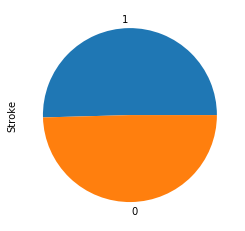

In [13]:
ytrain_OVSA.value_counts(dropna = False, normalize=True).plot(kind='pie')

### <span style="color:blue">Model regresji logistycznej</span>

In [14]:
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

Parameteres = {'C': np.power(10.0, np.arange(-3, 3))}
LR = LogisticRegression(warm_start = True)
LR_Grid = GridSearchCV(LR, param_grid = Parameteres, scoring = 'roc_auc', n_jobs = -1, cv=2)

LR_Grid.fit(Xtrain_OVSA, ytrain_OVSA) 
y_pred_LRC = LR_Grid.predict(Xtest)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Ocena modelu:

Recall Training data:      0.8115
Precision Training data:   0.7575
----------------------------------------------------------------------
Recall Test data:          0.7444
Precision Test data:       0.0504
----------------------------------------------------------------------
Confusion Matrix Test data
[[6865 2525]
 [  46  134]]
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      9390
           1       0.05      0.74      0.09       180

    accuracy                           0.73      9570
   macro avg       0.52      0.74      0.47      9570
weighted avg       0.98      0.73      0.83      9570



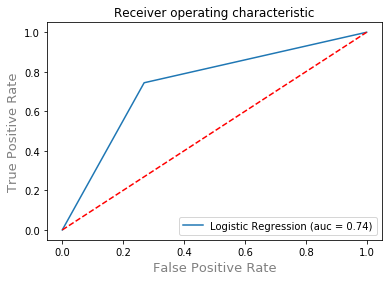

In [15]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, log_loss, auc, roc_curve, roc_auc_score, recall_score, precision_recall_curve
from sklearn.metrics import make_scorer, precision_score, fbeta_score, f1_score, classification_report

print("Recall Training data:     ", np.round(recall_score(ytrain_OVSA, LR_Grid.predict(Xtrain_OVSA)), decimals=4))
print("Precision Training data:  ", np.round(precision_score(ytrain_OVSA, LR_Grid.predict(Xtrain_OVSA)), decimals=4))
print("----------------------------------------------------------------------")
print("Recall Test data:         ", np.round(recall_score(ytest, LR_Grid.predict(Xtest)), decimals=4)) 
print("Precision Test data:      ", np.round(precision_score(ytest, LR_Grid.predict(Xtest)), decimals=4))
print("----------------------------------------------------------------------")
print("Confusion Matrix Test data")
print(confusion_matrix(ytest, LR_Grid.predict(Xtest)))
print("----------------------------------------------------------------------")
print(classification_report(ytest, LR_Grid.predict(Xtest)))
y_pred_proba = LR_Grid.predict_proba(Xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_LRC)
auc = metrics.roc_auc_score(ytest, y_pred_LRC)
plt.plot(fpr, tpr, label='Logistic Regression (auc = %0.2f)' % auc)
plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

### <span style="color:blue">4. Random Forest Classifier - with pipeline GridSearchCV</span>

Hiperparametry:
„n_estimators” - liczba drzew. Większa liczba drzew zwiększa wydajność i sprawia, że prognozy są bardziej stabilne, ale także spowalnia obliczenia.

„N_jobs” - ile procesorów jest dozwolone do użycia. Jeśli ma wartość 1, może używać tylko jednego procesora. Wartość „-1” oznacza, że nie ma limitu.

„Random_state” umożliwia replikację danych wyjściowych modelu. Model zawsze będzie dawał takie same wyniki, gdy ma określoną wartość random_state i jeśli otrzymał te same hiperparametry i te same dane treningowe.

„min_sample_leaf” minimalną liczbę listków wymaganych do podziału wewnętrznego węzła.

## <div class="alert-danger"> Uwaga! Czas obliczeń poniższego modelu trwa 25 minut dla próbki 29 tys.
Model został zamrożony dla zaoszczędzenia czasu.</div>   

### <span style="color:blue">Random Forest Classifier - simple version</span>
Hiperparametry dobrane ręcznie

In [16]:
from sklearn.ensemble import RandomForestClassifier

forestVC = RandomForestClassifier (random_state = 1, 
                                  n_estimators = 350, 
                                  max_depth = 2, 
                                  min_samples_split = 2, min_samples_leaf = 3) 
RFC_S = forestVC.fit(Xtrain_OVSA, ytrain_OVSA)
y_pred_RFC = RFC_S.predict(Xtest)

Ocena modelu:

Recall Training data:      0.8579
Precision Training data:   0.718
----------------------------------------------------------------------
Recall Test data:          0.8389
Precision Test data:       0.0434
----------------------------------------------------------------------
Confusion Matrix Test data
[[6061 3329]
 [  29  151]]
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.65      0.78      9390
           1       0.04      0.84      0.08       180

    accuracy                           0.65      9570
   macro avg       0.52      0.74      0.43      9570
weighted avg       0.98      0.65      0.77      9570



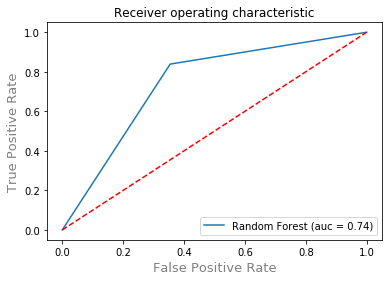

In [17]:
print("Recall Training data:     ", np.round(recall_score(ytrain_OVSA, RFC_S.predict(Xtrain_OVSA)), decimals=4))
print("Precision Training data:  ", np.round(precision_score(ytrain_OVSA, RFC_S.predict(Xtrain_OVSA)), decimals=4))
print("----------------------------------------------------------------------")
print("Recall Test data:         ", np.round(recall_score(ytest, RFC_S.predict(Xtest)), decimals=4)) 
print("Precision Test data:      ", np.round(precision_score(ytest, RFC_S.predict(Xtest)), decimals=4))
print("----------------------------------------------------------------------")
print("Confusion Matrix Test data")
print(confusion_matrix(ytest, RFC_S.predict(Xtest)))
print("----------------------------------------------------------------------")
print(classification_report(ytest, RFC_S.predict(Xtest)))
y_pred_proba = RFC_S.predict_proba(Xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_RFC)
auc = metrics.roc_auc_score(ytest, y_pred_RFC)
plt.plot(fpr, tpr, label='Random Forest (auc = %0.2f)' % auc)
plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

### <span style="color:blue">Naive Bayes Classifier</span>

In [18]:
from sklearn.naive_bayes import GaussianNB
NBC = GaussianNB()
NBC.fit(Xtrain_OVSA, ytrain_OVSA)

GaussianNB(priors=None, var_smoothing=1e-09)

y_pred_NBC = NBC.predict(Xtest)

Ocena modelu:

Recall Training data:      0.806
Precision Training data:   0.7394
----------------------------------------------------------------------
Recall Test data:          0.7778
Precision Test data:       0.0482
----------------------------------------------------------------------
Confusion Matrix Test data
[[6625 2765]
 [  40  140]]
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      9390
           1       0.05      0.78      0.09       180

    accuracy                           0.71      9570
   macro avg       0.52      0.74      0.46      9570
weighted avg       0.98      0.71      0.81      9570



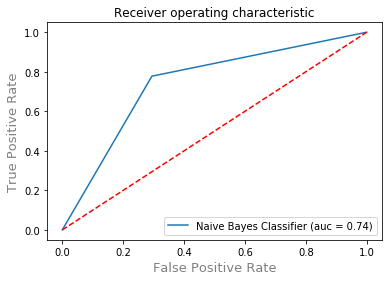

In [19]:
print("Recall Training data:     ", np.round(recall_score(ytrain_OVSA, NBC.predict(Xtrain_OVSA)), decimals=4))
print("Precision Training data:  ", np.round(precision_score(ytrain_OVSA, NBC.predict(Xtrain_OVSA)), decimals=4))
print("----------------------------------------------------------------------")
print("Recall Test data:         ", np.round(recall_score(ytest, NBC.predict(Xtest)), decimals=4)) 
print("Precision Test data:      ", np.round(precision_score(ytest, NBC.predict(Xtest)), decimals=4))
print("----------------------------------------------------------------------")
print("Confusion Matrix Test data")
print(confusion_matrix(ytest, NBC.predict(Xtest)))
print("----------------------------------------------------------------------")
print(classification_report(ytest, NBC.predict(Xtest)))
y_pred_proba = NBC.predict_proba(Xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_NBC)
auc = metrics.roc_auc_score(ytest, y_pred_NBC)
plt.plot(fpr, tpr, label='Naive Bayes Classifier (auc = %0.2f)' % auc)
plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

### <span style="color:blue">Support Vector Machine Classifier</span>

## <div class="alert-danger"> Uwaga! Czas obliczeń poniższego modelu trwa ponad 35 minut dla próbki 29 tys. 
Model został zamrożony dla zaoszczędzenia czasu.
</div>   

### <span style="color:blue">Support Vector Machine Classifier - simple version</span>

In [20]:
import time
start_time = time.time() ## pomiar czasu: start pomiaru czasu
print(time.ctime())
print('Pomiar czasu wykonania tego zadania')

Wed Mar  4 15:33:33 2020
Pomiar czasu wykonania tego zadania


In [21]:
from sklearn import svm

SVM_S = svm.SVC(kernel='linear')
SVM_S.fit(Xtrain_OVSA, ytrain_OVSA)
y_pred_SVM = SVM_S.predict(Xtest)

print(time.time() - start_time) ## koniec pomiaru czasu

1574.4111001491547


In [22]:
print("Recall Training data:     ", np.round(recall_score(ytrain_OVSA, SVM_S.predict(Xtrain_OVSA)), decimals=4))
print("Precision Training data:  ", np.round(precision_score(ytrain_OVSA, SVM_S.predict(Xtrain_OVSA)), decimals=4))
print("----------------------------------------------------------------------")
print("Recall Test data:         ", np.round(recall_score(ytest, SVM_S.predict(Xtest)), decimals=4)) 
print("Precision Test data:      ", np.round(precision_score(ytest, SVM_S.predict(Xtest)), decimals=4))
print("----------------------------------------------------------------------")
print("Confusion Matrix Test data")
print(confusion_matrix(ytest, SVM_S.predict(Xtest)))
print("----------------------------------------------------------------------")
print(classification_report(ytest, SVM_S.predict(Xtest)))


Recall Training data:      0.8443
Precision Training data:   0.7434
----------------------------------------------------------------------
Recall Test data:          0.7722
Precision Test data:       0.0463
----------------------------------------------------------------------
Confusion Matrix Test data
[[6527 2863]
 [  41  139]]
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      9390
           1       0.05      0.77      0.09       180

    accuracy                           0.70      9570
   macro avg       0.52      0.73      0.45      9570
weighted avg       0.98      0.70      0.80      9570



### Podsumowanie modeli klasyfikacji
- Modele osiagnęły wynik ROC od 73 do 89.
- Modele nie są przeuczone, ponieważ wartość Recall dla zbiorów testowych i treningowych miały podobne wartości.
- Istnieje bardzo duża różnica w mierniku 'precision' pomiedzy zmiennymi testowymi i treningowymi.
W modelach w zestawach testowych istnieje bardzo niski poziom 'precision'. Wynika to z ogromnego niezbilansowania zbiorów wynikowych. Tylko jeden pacjent na 52 doznaje udaru.
'Recall' jest miarą kompletności wyników.
'Precision' jest miarą 'zaśmiecenia wyników'.

<div class="alert-info">
<span style="color:darkblue">RECALL </span>definiuje się jako liczbę zjawisk: 'stroke' pobranych przez wyszukiwanie podzieloną przez całkowitą liczbę istniejących zjawisk: 'stroke'.

<span style="color:darkblue">PRECISION </span>definiuje się jako liczbę zjawisk: 'stroke' pobranych przez wyszukiwanie podzieloną przez całkowitą liczbę pacjentów pobranych przez to wyszukiwanie.
</div>

Aby udowodnić to, że powodem niskiego poziomu 'precision' jest niezbilansowanie testowego zbioru wynikowego przeprowadziłem krótkie doświadczenie. Wykonałem oversampling w zbiorze testowym, a następnie wstawiłem zbilansowany zbiór testowy do najprostszego z modeli: Naive Bayes Classifier


### Oversampling dla zbioru testowego

In [23]:
print("ytest = 0: ", sum(ytest == 0))
print("ytest = 1: ", sum(ytest == 1))

ytest = 0:  9390
ytest = 1:  180


In [24]:
ProporcjaT = sum(ytrain == 0) / sum(ytrain == 1) 
ProporcjaT = np.round(ProporcjaT, decimals=0)
ProporcjaT = Proporcja.astype(int)
print('Ilość 0 Stroke na 1 Stroke: ', ProporcjaT)

Ilość 0 Stroke na 1 Stroke:  52


In [25]:
ytest_OVSA = pd.concat([ytest[ytest==1]] * ProporcjaT, axis = 0) 
ytest_OVSA.count()

9360

In [26]:
Xtest_OVSA = pd.concat([Xtest.loc[ytest==1, :]] * ProporcjaT, axis = 0)
ytest_OVSA.count()

9360

In [27]:
ytest_OVSA = pd.concat([ytest, ytest_OVSA], axis = 0).reset_index(drop = True)
Xtest_OVSA = pd.concat([Xtest, Xtest_OVSA], axis = 0).reset_index(drop = True)

print("ilość elementów w zbiorze Xtrain:     ", Xtest.BMI.count())
print("ilość elementów w zbiorze Xtrain_OVSA: ", Xtest_OVSA.BMI.count())
print("ilość elementów w zbiorze ytrain:     ", ytest.count())
print("ilość elementów w zbiorze ytrain_OVSA: ", ytest_OVSA.count())

ilość elementów w zbiorze Xtrain:      9570
ilość elementów w zbiorze Xtrain_OVSA:  18930
ilość elementów w zbiorze ytrain:      9570
ilość elementów w zbiorze ytrain_OVSA:  18930


### Podstawienie Xtrain_OVSA do modelu Naive Bayes Classifier

In [28]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(Xtrain_OVSA, ytrain_OVSA)

GaussianNB(priors=None, var_smoothing=1e-09)

y_pred = gnb.predict(Xtest_OVSA)

In [29]:
print("Recall Training data:     ", np.round(recall_score(ytrain_OVSA, gnb.predict(Xtrain_OVSA)), decimals=4))
print("Precision Training data:  ", np.round(precision_score(ytrain_OVSA, gnb.predict(Xtrain_OVSA)), decimals=4))
print("----------------------------------------------------------------------")
print("Recall Test data:         ", np.round(recall_score(ytest_OVSA, gnb.predict(Xtest_OVSA)), decimals=4)) 
print("Precision Test data:      ", np.round(precision_score(ytest_OVSA, gnb.predict(Xtest_OVSA)), decimals=4))
print("----------------------------------------------------------------------")


Recall Training data:      0.806
Precision Training data:   0.7394
----------------------------------------------------------------------
Recall Test data:          0.7778
Precision Test data:       0.7285
----------------------------------------------------------------------


In [30]:
print(time.time() - start_time) ## koniec pomiaru czasu

1604.332447528839


Jak widać, model posiada podobne właściwości dla danych testowych i treningowych.
Eksperyment potwiedził, że powodem niskiego stanu 'precision' było wysokie niezbilansowanie zbioru testowego.

# <span style="color:darkblue">Wykorzystanie modeli w praktyce</span>

<div class="alert-warning">Przyjmijmy założenie, że do lekarza zgłasza się 62 pacjentów. Są to te osoby (rekordy), które nie brały udziału w ćwiczeniach i były od początku odseparowane. Osoby te chcą dowiedzieć się, czy są zagrożone udarem.</div>

In [31]:
grupa_testowa.head(3)

,ID,Gender,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke,Age_years,Age_years_10,Gender_C,Ever_Married_C,Type_Of_Work_C,Residence_C,Smoking_Status_C,Age_years_10_C
28999,40462,Male,0,0,No,Private,Urban,89.43,27.3,never smoked,0,22.115068,"(22.041, 29.055]",1,0,2,1,1,0
29000,35327,Female,0,0,No,Private,Urban,99.00,32.5,never smoked,0,49.106849,"(48.082, 53.126]",0,0,2,1,1,4
29001,35920,Female,0,0,Yes,Self-employed,Urban,75.91,26.7,never smoked,1,80.010959,"(74.11, 82.137]",0,1,3,1,1,8


Wprowadzam zmienną syntetyczną.

In [32]:
grupa_testowa['C_Factor'] = (grupa_testowa['BMI']+(5*(grupa_testowa['Age_years_10_C']*grupa_testowa['Smoking_Status_C'])))

In [33]:
grupa_testowa.head(3)

,ID,Gender,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke,Age_years,Age_years_10,Gender_C,Ever_Married_C,Type_Of_Work_C,Residence_C,Smoking_Status_C,Age_years_10_C,C_Factor
28999,40462,Male,0,0,No,Private,Urban,89.43,27.3,never smoked,0,22.115068,"(22.041, 29.055]",1,0,2,1,1,0,27.3
29000,35327,Female,0,0,No,Private,Urban,99.00,32.5,never smoked,0,49.106849,"(48.082, 53.126]",0,0,2,1,1,4,52.5
29001,35920,Female,0,0,Yes,Self-employed,Urban,75.91,26.7,never smoked,1,80.010959,"(74.11, 82.137]",0,1,3,1,1,8,66.7


In [34]:
grupa_testowa.reset_index()
grupa_testowa.index = np.arange(1, 64)
grupa_testowa.index

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63],
           dtype='int64')

#### Podział na zbiór zmiennych wynikowych i zmiennych niezależnych

In [35]:
grupa_testowa.describe(include=[np.number]).columns

Index(['ID', 'Hypertension', 'Heart_Disease', 'Avg_Glucose', 'BMI', 'Stroke',
       'Age_years', 'Gender_C', 'Ever_Married_C', 'Type_Of_Work_C',
       'Residence_C', 'Smoking_Status_C', 'Age_years_10_C', 'C_Factor'],
      dtype='object')

In [36]:
grupa_testowa.head(3)

,ID,Gender,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke,Age_years,Age_years_10,Gender_C,Ever_Married_C,Type_Of_Work_C,Residence_C,Smoking_Status_C,Age_years_10_C,C_Factor
1,40462,Male,0,0,No,Private,Urban,89.43,27.3,never smoked,0,22.115068,"(22.041, 29.055]",1,0,2,1,1,0,27.3
2,35327,Female,0,0,No,Private,Urban,99.00,32.5,never smoked,0,49.106849,"(48.082, 53.126]",0,0,2,1,1,4,52.5
3,35920,Female,0,0,Yes,Self-employed,Urban,75.91,26.7,never smoked,1,80.010959,"(74.11, 82.137]",0,1,3,1,1,8,66.7


In [37]:
grupa_testowa2 = grupa_testowa[['C_Factor','Hypertension','Heart_Disease','Avg_Glucose','BMI','Stroke','Age_years','Gender_C','Ever_Married_C','Type_Of_Work_C','Residence_C','Smoking_Status_C','Age_years_10_C']]
y_gt = grupa_testowa2['Stroke']
X_gt = grupa_testowa2.drop('Stroke', axis=1) 

In [38]:
grupa_testowa2.head(3)

,C_Factor,Hypertension,Heart_Disease,Avg_Glucose,BMI,Stroke,Age_years,Gender_C,Ever_Married_C,Type_Of_Work_C,Residence_C,Smoking_Status_C,Age_years_10_C
1,27.3,0,0,89.43,27.3,0,22.115068,1,0,2,1,1,0
2,52.5,0,0,99.00,32.5,0,49.106849,0,0,2,1,1,4
3,66.7,0,0,75.91,26.7,1,80.010959,0,1,3,1,1,8


In [39]:
df2.head(3)

,C_Factor,Hypertension,Heart_Disease,Avg_Glucose,BMI,Stroke,Age_years,Gender_C,Ever_Married_C,Type_Of_Work_C,Residence_C,Smoking_Status_C,Age_years_10_C
0,64.2,1,0,87.96,39.2,0,58.093151,1,1,2,1,1,5
1,35.9,0,0,69.04,35.9,0,70.076712,0,1,2,0,0,7
2,17.7,0,0,77.59,17.7,0,52.041096,0,1,2,1,0,4


In [40]:
X_gt.head(3)

,C_Factor,Hypertension,Heart_Disease,Avg_Glucose,BMI,Age_years,Gender_C,Ever_Married_C,Type_Of_Work_C,Residence_C,Smoking_Status_C,Age_years_10_C
1,27.3,0,0,89.43,27.3,22.115068,1,0,2,1,1,0
2,52.5,0,0,99.00,32.5,49.106849,0,0,2,1,1,4
3,66.7,0,0,75.91,26.7,80.010959,0,1,3,1,1,8


### RFC_S

In [41]:
y_pred_RFC_S = RFC_S.predict(X_gt)
y_pred_RFC_S

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1],
      dtype=int64)

In [42]:
RFC_S_model=pd.Series(y_pred_RFC_S).reset_index()
RFC_S_model.columns =['index','RFC_S_model']
RFC_S_model.index = np.arange(1, 64)
#grupa_testowa.index

### LR_Grid

In [43]:
y_pred_LR_Grid = LR_Grid.predict(X_gt)
y_pred_LR_Grid

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
      dtype=int64)

In [44]:
LR_Grid_model=pd.Series(y_pred_LR_Grid).reset_index()
LR_Grid_model.columns =['index','LR_Grid_model']
LR_Grid_model.index = np.arange(1, 64)
#grupa_testowa.index

### Naive Bayes Classifier 

In [45]:
y_pred_NBC = NBC.predict(X_gt)
y_pred_NBC

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
      dtype=int64)

In [46]:
NBC_model=pd.Series(y_pred_NBC).reset_index()
NBC_model.columns =['index','NBC_model']
NBC_model.index = np.arange(1, 64)
#grupa_testowa.index

### Support Vector Machine Classifier - simple version

In [47]:
y_pred_SVM = SVM_S.predict(X_gt)
y_pred_SVM

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
      dtype=int64)

In [48]:
SVM_model=pd.Series(y_pred_SVM).reset_index()
SVM_model.columns =['index','SVM_model']
SVM_model.index = np.arange(1, 64)
#grupa_testowa.index

### <span style="color:darkblue">Komitet modeli</span>
<div class="alert-warning">Teraz lekarz na podstawie numeru indexu pacjenta może sprawdzić, czy pacjent jest zagrożony udarem czy ewentualnie miał udar.
Lekarz ma do wyboru cztery modele machine learning.</div>

In [52]:
grupa_testow = pd.concat([grupa_testowa,LR_Grid_model,RFC_S_model,NBC_model,SVM_model],axis=1, sort=False)
grupa_testow[['Stroke','LR_Grid_model','RFC_S_model','NBC_model','SVM_model']].head(6)

,Stroke,LR_Grid_model,RFC_S_model,NBC_model,SVM_model
1,0,0,0,0,0
2,0,0,0,0,0
3,1,1,1,1,1
4,0,1,1,1,1
5,0,0,0,0,0
6,0,0,0,0,0


### Ocena końcowa modeli na podstawie grupy 62 nowych pacjentów

----------------------------------------------------------------------
Recall LR_Grid_model:          1.0
Precision LR_Grid_model:       0.0952
----------------------------------------------------------------------
Recall RFC_S_model:          1.0
Precision RFC_S_model:       0.0769
----------------------------------------------------------------------
Recall NBC_model:          1.0
Precision NBC_model:       0.0952
----------------------------------------------------------------------
Recall SVM_model:          1.0
Precision SVM_model:       0.087
----------------------------------------------------------------------


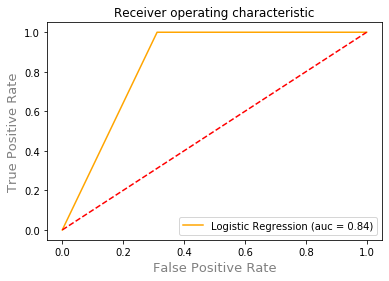

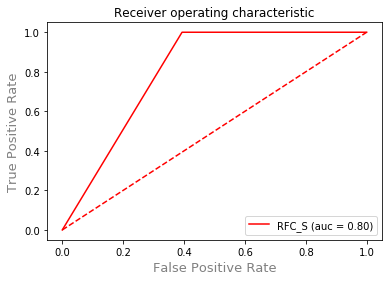

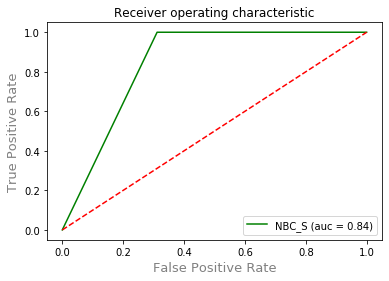

In [53]:
print("----------------------------------------------------------------------")
print("Recall LR_Grid_model:         ", np.round(recall_score(y_gt, LR_Grid.predict(X_gt)), decimals=4)) 
print("Precision LR_Grid_model:      ", np.round(precision_score(y_gt, LR_Grid.predict(X_gt)), decimals=4))
print("----------------------------------------------------------------------")
print("Recall RFC_S_model:         ", np.round(recall_score(y_gt, RFC_S.predict(X_gt)), decimals=4)) 
print("Precision RFC_S_model:      ", np.round(precision_score(y_gt, RFC_S.predict(X_gt)), decimals=4))
print("----------------------------------------------------------------------")
print("Recall NBC_model:         ", np.round(recall_score(y_gt, NBC.predict(X_gt)), decimals=4)) 
print("Precision NBC_model:      ", np.round(precision_score(y_gt, NBC.predict(X_gt)), decimals=4))
print("----------------------------------------------------------------------")
print("Recall SVM_model:         ", np.round(recall_score(y_gt, SVM_S.predict(X_gt)), decimals=4)) 
print("Precision SVM_model:      ", np.round(precision_score(y_gt, SVM_S.predict(X_gt)), decimals=4))
print("----------------------------------------------------------------------")





#print(classification_report(y_gt, LR_Grid.predict(X_gt)))
#print(classification_report(y_gt, LR_Grid.predict(X_gt)))

# LR_Grid
y_pred_proba = LR_Grid.predict_proba(X_gt)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_gt,  y_pred_LR_Grid)
auc = metrics.roc_auc_score(y_gt, y_pred_LR_Grid)
plt.plot(fpr, tpr, color='orange',label='Logistic Regression (auc = %0.2f)' % auc)
plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

#RFC_S
y_pred_proba = RFC_S.predict_proba(X_gt)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_gt,  y_pred_RFC_S)
auc = metrics.roc_auc_score(y_gt, y_pred_RFC_S)
plt.plot(fpr, tpr, color='red',label='RFC_S (auc = %0.2f)' % auc)
plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

#NBC
y_pred_proba = NBC.predict_proba(X_gt)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_gt,  y_pred_NBC)
auc = metrics.roc_auc_score(y_gt, y_pred_NBC)
plt.plot(fpr, tpr, color='green',label='NBC_S (auc = %0.2f)' % auc)
plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.show()


#SVM
#y_pred_proba = SVM_S.predict_proba(X_gt)[::,1]
#fpr, tpr, _ = metrics.roc_curve(y_gt,  y_pred_SVM)
#auc = metrics.roc_auc_score(y_gt, y_pred_SVM)
#plt.plot(fpr, tpr, color='green',label='SVM (auc = %0.2f)' % auc)
#plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
#plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
#plt.title('Receiver operating characteristic')
#plt.legend(loc="lower right")
#plt.legend(loc=4)
#plt.plot([0, 1], [0, 1],'r--')
#plt.show()
